1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


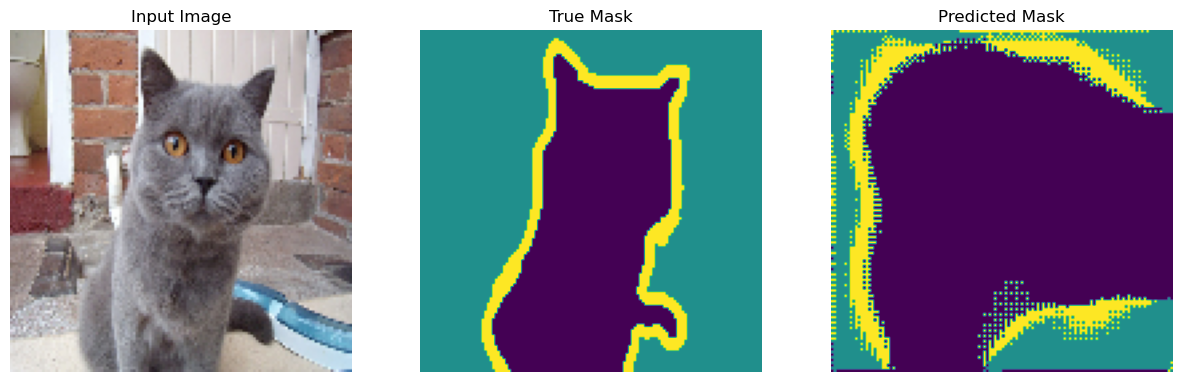


Sample Prediction after epoch 1

57/57 ━━━━━━━━━━━━━━━━━━━━ 18323s 327s/step - accuracy: 0.5934 - loss: 0.9982 - val_accuracy: 0.5094 - val_loss: 178.4659
Epoch 2/50
45/57 ━━━━━━━━━━━━━━━━━━━━ 1:11:05 355s/step - accuracy: 0.7541 - loss: 0.6279

In [1]:
# ADDED VERTICAL FLIPPING TO AUGMENTATION

import tensorflow as tf

import tensorflow_datasets as tfds

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt


dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

"""The dataset already contains the required training and test splits, so continue to use the same splits:"""

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

"""The following class performs a simple augmentation by randomly-flipping an image.
Go to the [Image augmentation](data_augmentation.ipynb) tutorial to learn more.

"""

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="vertical", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

"""Build the input pipeline, applying the augmentation after batching the inputs:"""

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

"""Visualize an image example and its corresponding mask from the dataset:"""

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

"""## Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.
"""

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

"""The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:"""

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    x = inputs
    skips = []
    for filter_size in [64, 128, 256, 512]:
        x = tf.keras.layers.Conv2D(filter_size, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filter_size, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        skips.append(x)
        x = tf.keras.layers.MaxPooling2D(2)(x)
        x = tf.keras.layers.Dropout(0.5)(x)

    # Middle part of the network
    x = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Upsampling and establishing the skip connections
    skips = reversed(skips)
    for filter_size, skip in zip([512, 256, 128, 64], skips):
        x = tf.keras.layers.Conv2DTranspose(filter_size, 2, strides=2, padding='same')(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])
        x = tf.keras.layers.Conv2D(filter_size, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filter_size, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    # This is the last layer of the model
    last = tf.keras.layers.Conv2D(output_channels, 3, padding='same')  # Maintain 128x128 resolution

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

"""Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

Since this is a multiclass classification problem, use the `tf.keras.losses.SparseCategoricalCrossentropy` loss function with the `from_logits` argument set to `True`, since the labels are scalar integers instead of vectors of scores for each pixel of every class.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.
"""

OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

"""Plot the resulting model architecture:"""

tf.keras.utils.plot_model(model, show_shapes=True)

"""Try out the model to check what it predicts before training:"""

def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

"""The callback defined below is used to observe how the model improves while it is training:"""

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

"""## Make predictions

Now, make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.
"""

show_predictions(test_batches, 3)

"""## Optional: Imbalanced classes and class weights

Semantic segmentation datasets can be highly imbalanced meaning that particular class pixels can be present more inside images than that of other classes. Since segmentation problems can be treated as per-pixel classification problems, you can deal with the imbalance problem by weighing the loss function to account for this. It's a simple and elegant way to deal with this problem. Refer to the [Classification on imbalanced data](../structured_data/imbalanced_data.ipynb) tutorial to learn more.

To [avoid ambiguity](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` does not support the `class_weight` argument for targets with 3+ dimensions.
"""

try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

"""So, in this case you need to implement the weighting yourself. You'll do this using sample weights: In addition to `(data, label)` pairs, `Model.fit` also accepts `(data, label, sample_weight)` triples.

Keras `Model.fit` propagates the `sample_weight` to the losses and metrics, which also accept a `sample_weight` argument. The sample weight is multiplied by the sample's value before the reduction step. For example:
"""

# label = [0,0]
# prediction = [[-3., 0], [-3, 0]]
# sample_weight = [1, 10]

# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
#                                                reduction=tf.keras.losses.Reduction.NONE)
# loss(label, prediction, sample_weight).numpy()

# """So, to make sample weights for this tutorial, you need a function that takes a `(data, label)` pair and returns a `(data, label, sample_weight)` triple where the `sample_weight` is a 1-channel image containing the class weight for each pixel.

# The simplest possible implementation is to use the label as an index into a `class_weight` list:
# """

# def add_sample_weights(image, label):
#   # The weights for each class, with the constraint that:
#   #     sum(class_weights) == 1.0
#   class_weights = tf.constant([2.0, 2.0, 1.0])
#   class_weights = class_weights/tf.reduce_sum(class_weights)

#   # Create an image of `sample_weights` by using the label at each pixel as an
#   # index into the `class weights` .
#   sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

#   return image, label, sample_weights

# """The resulting dataset elements contain 3 images each:"""

# train_batches.map(add_sample_weights).element_spec

# """Now, you can train a model on this weighted dataset:"""

# weighted_model = unet_model(OUTPUT_CLASSES)
# weighted_model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=['accuracy'])

# weighted_model.fit(
#     train_batches.map(add_sample_weights),
#     epochs=1,
#     steps_per_epoch=10)


In [ ]:
import tensorflow as tf

label = [0, 0]
prediction = [[-3., 0], [-3, 0]]
sample_weight = [1, 10]

# Convert lists to tensors
label_tensor = tf.constant(label)
prediction_tensor = tf.constant(prediction)
sample_weight_tensor = tf.constant(sample_weight)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction=tf.keras.losses.Reduction.NONE)
# Use tensors instead of lists
loss_value = loss(label_tensor, prediction_tensor, sample_weight_tensor).numpy()
print(loss_value)

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
def evaluate_model(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')

    # Generate predictions
    y_true = np.array([])
    y_pred = np.array([])
    for datapoint in test_dataset.unbatch().batch(1).take(-1):
        image, mask = datapoint
        pred_mask = model.predict(image)
        y_true = np.append(y_true, mask.numpy().flatten())
        y_pred = np.append(y_pred, np.argmax(pred_mask, axis=-1).flatten())

    # Calculate metrics
    conf_mat = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    iou = tf.keras.metrics.MeanIoU(num_classes=3)
    iou.update_state(y_true, y_pred)
    iou_score = iou.result().numpy()

    # Print metrics
    print(f'Confusion Matrix:\n{conf_mat}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'IoU: {iou_score}')

    # Plot metrics
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(conf_mat, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.bar(['Precision', 'Recall', 'F1', 'IoU'], [precision, recall, f1, iou_score])
    plt.title('Metrics')
    plt.show()

# Assuming GradCAM and display_best_worst_images are implemented correctly elsewhere in your code.

# Main pipeline
if __name__ == "__main__":
    dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
    train_dataset = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)
    test_dataset = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32)
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    history = model.fit(train_dataset, epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=test_dataset,
                        validation_steps=VALIDATION_STEPS)
    evaluate_model(model, test_dataset)
    # Generate Grad-CAM visualizations for a sample image
    for image, mask in test_dataset.take(1):
        # generate_gradcam(model, image)
        pass
    # display_best_worst_images(model, test_dataset)

In [ ]:
# plot accuracy for train and test by epoch
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# plot loss function for train and test by epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


In [ ]:
def display_images(images, titles, cols=3):
    """Display images with titles in a grid."""
    assert len(images) == len(titles)
    rows = len(images) // cols + int(len(images) % cols > 0)
    plt.figure(figsize=(cols * 4, rows * 4))
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.title(title)
        plt.axis('off')
    plt.show()

def evaluate_and_display_best_worst_images(model, dataset, num_images=3):
    accuracies = []
    images = []
    masks = []
    predictions = []

    # Iterate over the dataset to gather predictions and their true labels
    for image_batch, mask_batch in dataset:
        pred_mask_batch = model.predict(image_batch)
        for image, true_mask, pred_mask in zip(image_batch, mask_batch, pred_mask_batch):
            # Calculate accuracy for each prediction
            pred_mask_argmax = tf.math.argmax(pred_mask, axis=-1)
            accuracy = np.mean(true_mask.numpy().flatten() == pred_mask_argmax.numpy().flatten())
            accuracies.append(accuracy)
            images.append(image)
            masks.append(true_mask)
            predictions.append(pred_mask_argmax)

    # Sort predictions by accuracy
    sorted_indices = np.argsort(accuracies)
    best_indices = sorted_indices[-num_images:]
    worst_indices = sorted_indices[:num_images]

    # Display best predictions
    best_images = [images[i] for i in best_indices]
    best_titles = [f"Best {i+1}: Acc={accuracies[i]:.2f}" for i in best_indices]
    display_images(best_images, best_titles)

    # Display worst predictions
    worst_images = [images[i] for i in worst_indices]
    worst_titles = [f"Worst {i+1}: Acc={accuracies[i]:.2f}" for i in worst_indices]
    display_images(worst_images, worst_titles)

# Assuming 'model' is your trained model and 'test_dataset' is your testing dataset
evaluate_and_display_best_worst_images(model, test_dataset, num_images=3)

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions. Ensure model.inputs is correctly passed.
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,  # Corrected this line
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        print(preds.shape)
        # if pred_index is None:
        #     pred_index = tf.argmax(preds[0])
        #     pred_index = pred_index.numpy()  # Convert to numpy if it's a tensor
        #     if isinstance(pred_index, np.ndarray):  # Ensure it's a scalar
        #         pred_index = pred_index.item()
        pred_index = 0
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with respect to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()

In [ ]:
# Assuming 'last_conv_layer_name' is the name of the last conv layer in your model
last_conv_layer_name = 'conv2d_37'
for image, mask in test_dataset.take(1):
    img_array = tf.expand_dims(image[0], axis=0)  # Select the first image in the batch
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    display_gradcam(image[0], heatmap)

In [ ]:
def evaluate_and_display_best_worst_images_with_gradcam(model, dataset, last_conv_layer_name, num_images=3):
    accuracies = []
    images = []
    masks = []
    predictions = []

    # Iterate over the dataset to gather predictions and their true labels
    for image_batch, mask_batch in dataset:
        pred_mask_batch = model.predict(image_batch)
        for image, true_mask, pred_mask in zip(image_batch, mask_batch, pred_mask_batch):
            # Calculate accuracy for each prediction
            pred_mask_argmax = tf.math.argmax(pred_mask, axis=-1)
            accuracy = np.mean(true_mask.numpy().flatten() == pred_mask_argmax.numpy().flatten())
            accuracies.append(accuracy)
            images.append(image.numpy())
            masks.append(true_mask)
            predictions.append(pred_mask_argmax)

    # Sort predictions by accuracy
    sorted_indices = np.argsort(accuracies)
    best_indices = sorted_indices[-num_images:]
    worst_indices = sorted_indices[:num_images]

    # Prepare to display images and their Grad-CAM heatmaps
    selected_images = [images[i] for i in np.concatenate([best_indices, worst_indices])]
    selected_titles = [f"Best {i+1}" for i in range(num_images)] + [f"Worst {i+1}" for i in range(num_images)]

    cols = 3
    rows = (len(selected_images) // cols) + int(len(selected_images) % cols > 0)
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, image in enumerate(selected_images):
        plt.subplot(rows, cols, i + 1)
        img_array = np.expand_dims(image, axis=0)
        # Use a fixed pred_index for visualization
        pred_index = 0
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_index)
        display_gradcam(image, heatmap)
        plt.title(selected_titles[i])

    plt.show()

# Assuming 'last_conv_layer_name' is the name of the last conv layer in your model
last_conv_layer_name = 'conv2d_37'
for image, mask in test_dataset.take(1):
    img_array = tf.expand_dims(image[0], axis=0)  # Select the first image in the batch
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    evaluate_and_display_best_worst_images_with_gradcam(model, test_dataset, last_conv_layer_name, num_images=3)

